# Orientation Tuning Analysis Pipeline

This notebook demonstrates the complete workflow for analyzing 2-photon calcium imaging data:
1. FOV configuration setup
2. Suite2P trace extraction
3. Trial organization and response calculation
4. Orientation/direction tuning analysis
5. Comprehensive visualization

## Requirements
```bash
pip install numpy scipy matplotlib h5py
```

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from fov_config_suite2p import FOV
from fov_utils import create_fov_from_stimfile, export_fov_to_dict
from ophys_analysis import (
    extract_suite2p_traces,
    save_extraction_hdf5,
    load_extraction_hdf5,
    plot_population_summary,
    plot_orientation_map,
    plot_tuning_distributions,
    plot_cell_tuning_curve,
    create_full_analysis_report,
    get_tuning_madineh,
    get_well_fit_cells,
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## 1. FOV Configuration

Create FOV configuration from stimulus file and set required parameters.

In [8]:
# Example paths - UPDATE THESE FOR YOUR DATA
data_dir = Path(r"X:\Experimental_Data\BrainImaging\20251113_Derrick")

# IMPORTANT: Spk2File should be the ACTUAL directory number, not a list index!
# For directory t00016/, use Spk2File=[16], not [0]
# Check your data directory to find the correct t* folder number

# Create FOV from stimulus file
fov = create_fov_from_stimfile(
    stimfile=None,      # Auto-detect .py file in Spk2 subdirectory
    TifStack_path=str(data_dir),
    ImagingFile=[0],    # Imaging file indices
    Spk2File=[16],      # Actual Spk2 directory number (for t00016/)
    factor=1,           # Optional parameters
    brain_region='V1'
)

# Display configuration
print("\nFOV Configuration:")
print("="*50)
for key, val in export_fov_to_dict(fov).items():
    print(f"{key:20s}: {val}")

  Auto-detected stimulus file: t00016\driftinggrating_orientation.py
  ✓ Extracted animal name: Derrick
  ✓ Extracted date: 2025-11-13
  → Parsing stimulus file: driftinggrating_orientation.py
  ✓ Populated: stim_dur=4.0s, postPeriod=2.0s, stim_type='grating', have_blank=1

FOV Configuration:
animal_name         : Derrick
TifStack_path       : X:\Experimental_Data\BrainImaging\20251113_Derrick
ImagingFile         : [0]
Spk2File            : [16]
factor              : 1
sampRate            : 30.0
fileImagingind      : 1
stim_dur            : 4.0
prePeriod           : 0.5
postPeriod          : 2.0
stim_type           : grating
fly_back            : 0
brain_region        : V1
recording_date      : 2025-11-13T00:00:00
zoom                : 3
piezo_planes        : 0
current_plane       : 1
two_chan            : 0
use_registered      : 0
registration_type   : Smooth
extraction          : suite2p
badTrials           : [0]
thresh              : 0
have_blank          : 1
EPI_data            : 0

## 2. Extract Suite2P Traces

Load Suite2P output and organize into trial structure.

In [9]:
# Run extraction
ce = extract_suite2p_traces(fov, fnum=0)

# Print summary
ce.print_summary()

# Get basic statistics
n_cells = len(ce.cells)
n_responsive = sum(c.ROI_responsiveness for c in ce.cells)

print(f"\n{'='*50}")
print(f"Total cells extracted: {n_cells}")
print(f"Visually responsive: {n_responsive} ({100*n_responsive/n_cells:.1f}%)")
print(f"Non-responsive: {n_cells - n_responsive}")


Extracting Suite2P Traces
  Animal: Derrick
  Path: X:\Experimental_Data\BrainImaging\20251113_Derrick
  Imaging file: 0, Spike2 file: 16

  Loading Spike2 timing data...
  Loaded 9 unique stimulus codes
  Loaded 90 stimulus presentations
  Loading Suite2P data from: X:\Experimental_Data\BrainImaging\20251113_Derrick\t0\suite2p\plane0\Fall.mat

  Processing 161 ROIs...
    Processing ROI 50/161
    Processing ROI 100/161
    Processing ROI 150/161

  Organizing into trials...
    Stimuli: 9, Trials per stimulus: 10
    Pre-period: 16 frames, Stim: 121 frames, Post: 61 frames

  ✓ Extraction complete!

Cell Extraction Summary
Total cells:          161
Responsive cells:     124
Fraction responsive:  77.02%
Animal:               Derrick
Brain region:         V1
Recording date:       2025-11-13 00:00:00
Stimulus type:        grating

Cell Extraction Summary
Total cells:          161
Responsive cells:     124
Fraction responsive:  77.02%
Animal:               Derrick
Brain region:         

## 3. Save Extraction Results

Save to HDF5 for later analysis.

In [10]:
# Save to HDF5
output_file = data_dir / "extraction_results.h5"
save_extraction_hdf5(ce, str(output_file))

# Verify by loading
ce_loaded = load_extraction_hdf5(str(output_file))
print(f"\nVerified: Loaded {len(ce_loaded.cells)} cells from saved file")

✓ Saved to X:\Experimental_Data\BrainImaging\20251113_Derrick\extraction_results.h5
✓ Loaded 161 cells from X:\Experimental_Data\BrainImaging\20251113_Derrick\extraction_results.h5

Verified: Loaded 161 cells from saved file


## 4. Population Summary

Visualize overall population statistics.

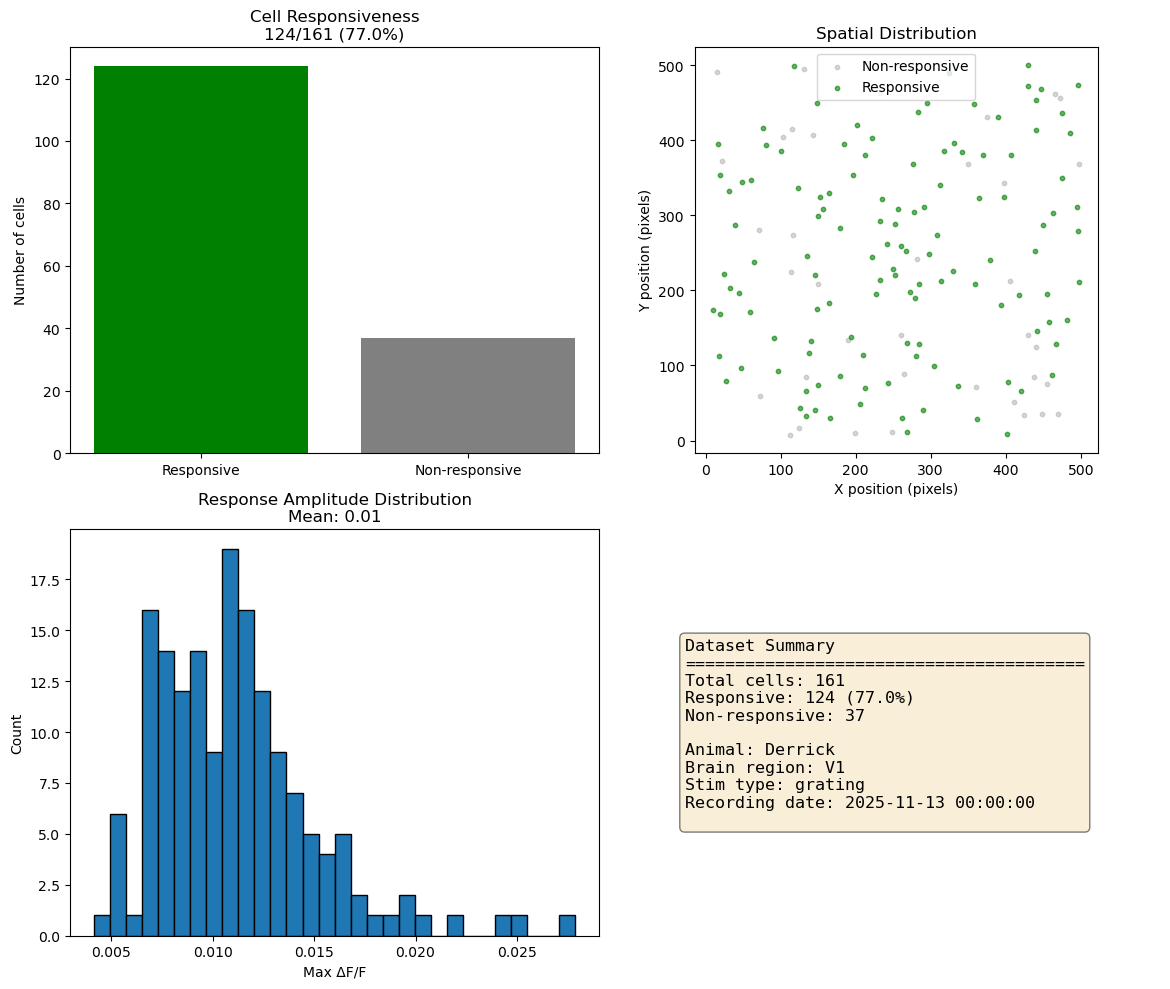

In [11]:
plot_population_summary(ce)

In [13]:
# Check if trial data exists
print(f"Number of cells: {len(ce.cells)}")
print(f"First cell cyc shape: {ce.cells[0].cyc.shape}")
print(f"First cell cyc data (sample): {ce.cells[0].cyc[0, 0, :10]}")  # First 10 timepoints of first trial
print(f"Unique stims: {ce.cells[0].uniqStims}")
print(f"Number of non-zero values in cyc: {np.sum(ce.cells[0].cyc != 0)}")

Number of cells: 161
First cell cyc shape: (9, 10, 182)
First cell cyc data (sample): [ 0.01407321 -0.0316139  -0.03837442 -0.00395406 -0.04634323 -0.02422977
 -0.00182104  0.21883994  0.08005132  0.01420925]
Unique stims: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
Number of non-zero values in cyc: 4019


## 5. Tuning Distributions

Analyze orientation and direction selectivity across the population.

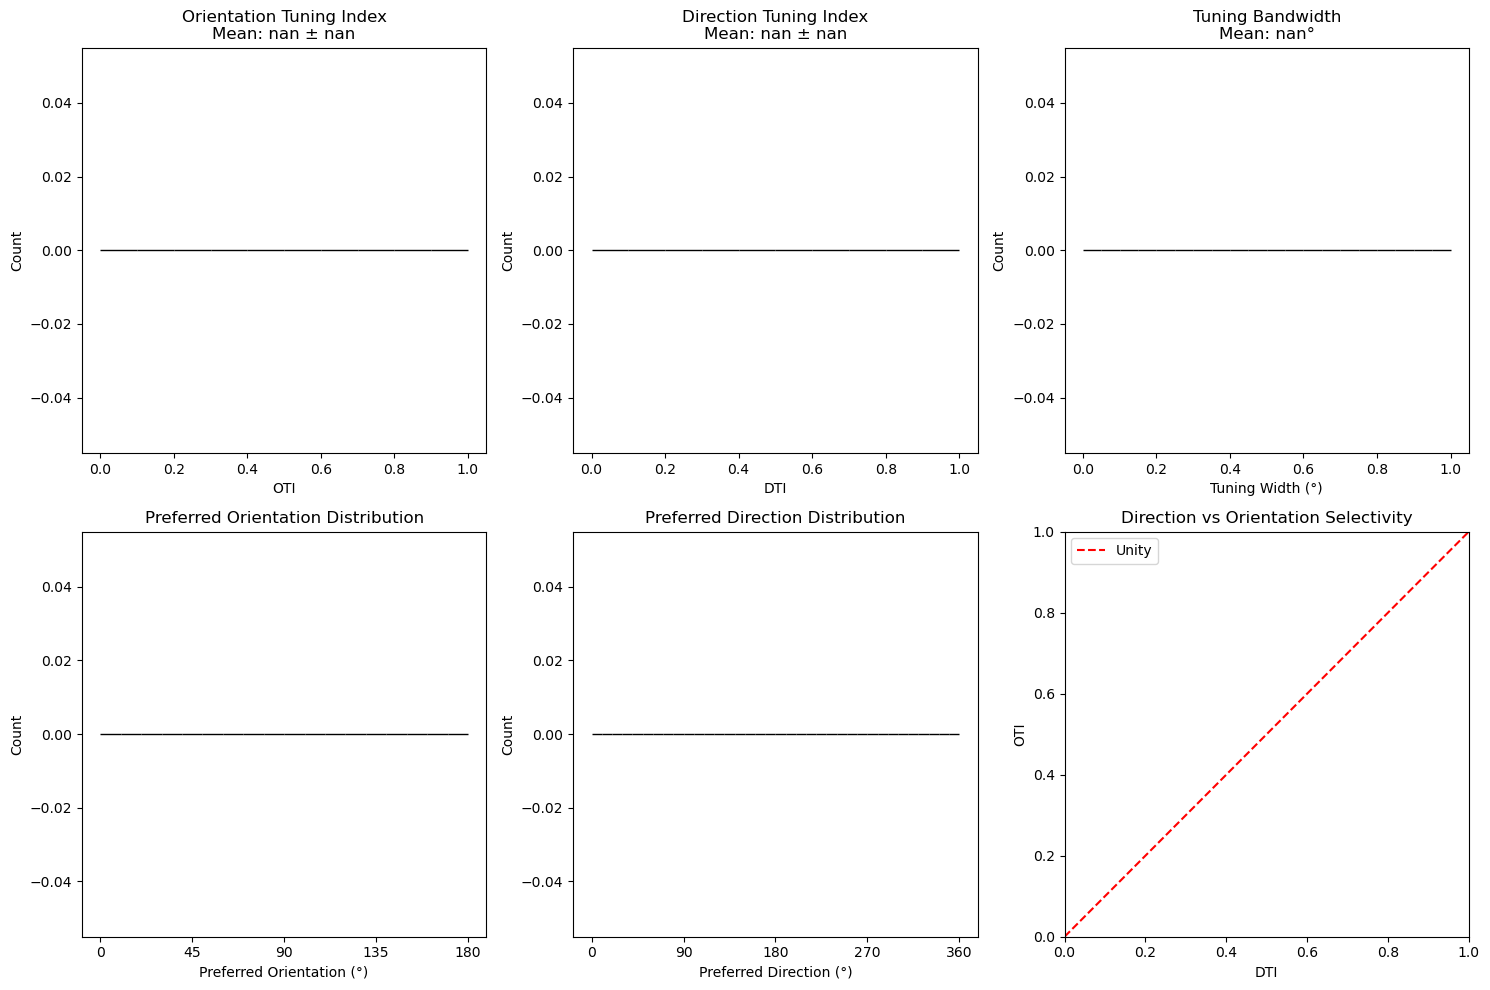

In [17]:
plot_tuning_distributions(ce)

## 6. Orientation/Direction Preference Maps

Visualize spatial organization of tuning preferences.

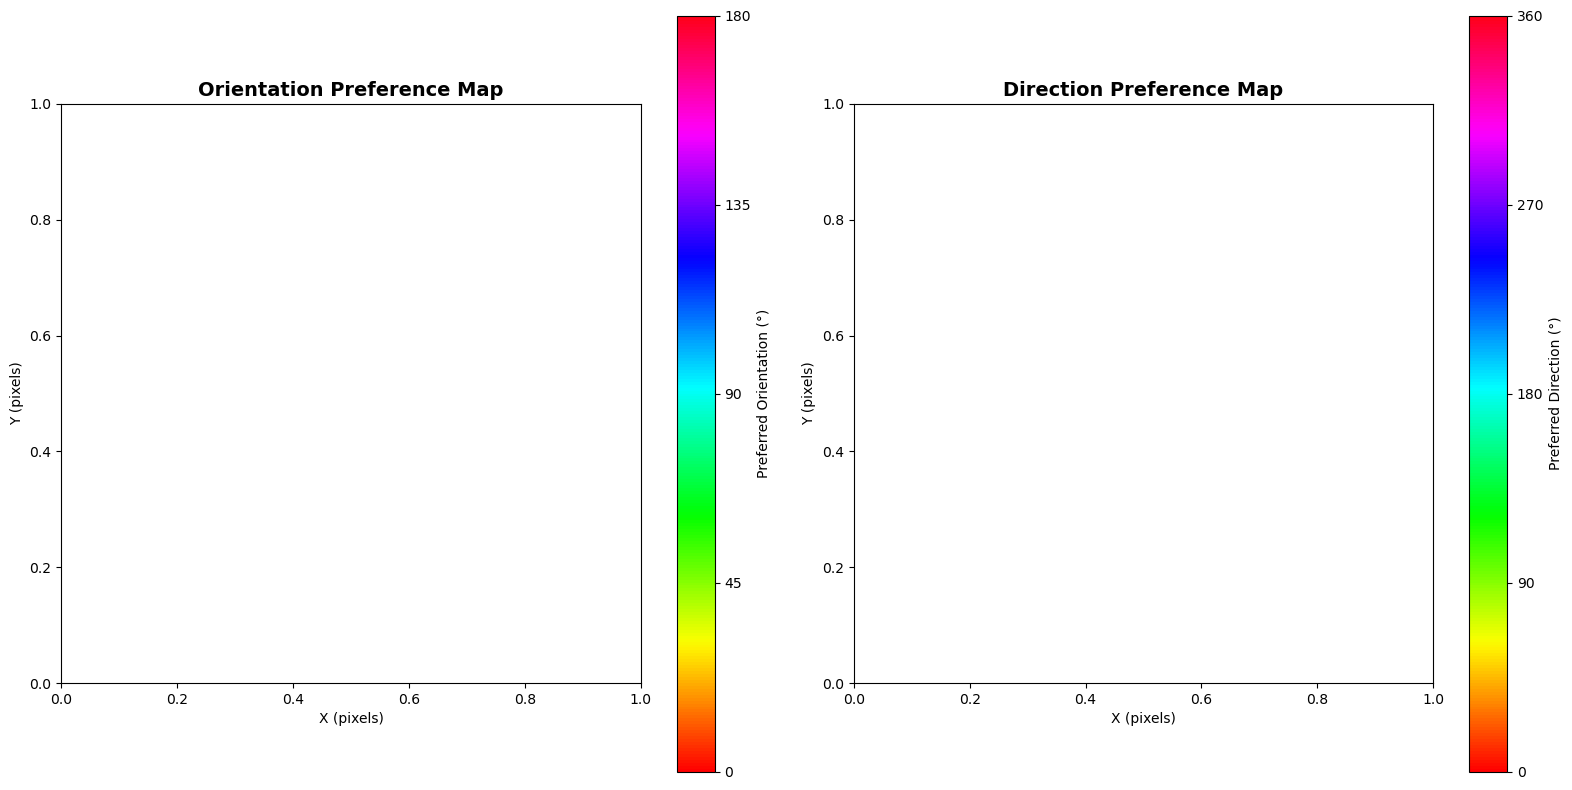

In [14]:
# Optional: Load FOV image for background
# fov_image = np.load(data_dir / "mean_image.npy")
fov_image = None

plot_orientation_map(ce, fov_image=fov_image)

## 7. Individual Cell Analysis

Examine tuning curves for individual responsive cells.

In [15]:
# Get responsive cell indices
responsive_indices = [i for i, c in enumerate(ce.cells) if c.ROI_responsiveness]
print(f"Analyzing {len(responsive_indices)} responsive cells\n")

# Plot first 5 responsive cells
for idx in responsive_indices[:5]:
    cell = ce.cells[idx]
    
    # Get stimulus info
    n_dirs = len(cell.uniqStims) - 1  # Exclude blank
    stimInfo = np.arange(0, 360, 360/n_dirs)
    
    # Get tuning metrics
    tuning, _, fitdata = get_tuning_madineh(cell.condition_response[:n_dirs], stimInfo)
    
    # Plot
    plot_cell_tuning_curve(cell, stimInfo, tuning, fitdata, idx, fov.stim_dur)
    
    # Print metrics
    print(f"Cell {idx}:")
    print(f"  Preferred Orientation: {tuning['pref_ort_fit']:.1f}°")
    print(f"  OTI: {tuning['oti_vec']:.3f}")
    print(f"  Preferred Direction: {tuning['pref_dir_fit']:.1f}°")
    print(f"  DTI: {tuning['dti_vec']:.3f}")
    print(f"  Bandwidth: {tuning['fit_bandwidth']:.1f}°")
    print(f"  Fit correlation: {tuning['fit_r']:.3f}")
    print()

Analyzing 124 responsive cells



TypeError: bad operand type for abs(): 'list'

## 8. Generate Complete Analysis Report

Create all analysis figures and save to output directory.

In [ ]:
# Create output directory with ImagingFile subfolder (e.g., t0, t1, etc.)
imaging_file_num = fov.ImagingFile[0] if isinstance(fov.ImagingFile, list) else fov.ImagingFile
output_dir = data_dir / "analysis_report" / f"t{imaging_file_num}"

# Generate all plots for all responsive cells
create_full_analysis_report(ce, fov_image=fov_image, output_dir=str(output_dir))

# Alternative: Only include cells with good Gaussian fit (fit_r >= 0.9)
# This filters orientation maps and tuning distributions to well-fit cells only
output_dir_filtered = data_dir / "analysis_report" / f"t{imaging_file_num}_well_fit"
create_full_analysis_report(ce, fov_image=fov_image, output_dir=str(output_dir_filtered),
                            fit_r_threshold=0.9)

print(f"\nAnalysis report saved to: {output_dir}")
print(f"Filtered report (fit_r >= 0.9) saved to: {output_dir_filtered}")

## 9. Advanced Analysis Examples

### Filter cells by Gaussian fit quality

Use the `get_well_fit_cells` helper function to get indices of cells with good tuning curve fits.

In [ ]:
# Get cells with good Gaussian fit quality (fit_r >= 0.9)
well_fit_indices = get_well_fit_cells(ce, fit_r_threshold=0.9)
print(f"Found {len(well_fit_indices)} cells with fit_r >= 0.9")
print(f"Indices: {well_fit_indices[:15]}...")  # Show first 15

# You can use these indices for any analysis function:
# - plot_orientation_map(ce, cell_indices=well_fit_indices)
# - plot_tuning_distributions(ce, cell_indices=well_fit_indices)
# - create_full_analysis_report(ce, cell_indices=well_fit_indices, ...)

In [ ]:
# Find orientation-selective cells (high OTI, low DTI)
orientation_selective = []

for i, cell in enumerate(ce.cells):
    if cell.ROI_responsiveness:
        n_dirs = len(cell.uniqStims) - 1
        stimInfo = np.arange(0, 360, 360/n_dirs)
        try:
            tuning, _, _ = get_tuning_madineh(cell.condition_response[:n_dirs], stimInfo)
            
            # Criteria: OTI > 0.3, DTI < 0.3
            if tuning['oti_fit'] > 0.3 and tuning['dti_fit'] < 0.3:
                orientation_selective.append(i)
        except:
            pass

print(f"Found {len(orientation_selective)} orientation-selective cells")
print(f"Indices: {orientation_selective[:10]}...")  # Show first 10

In [ ]:
# Find direction-selective cells (high DTI)
direction_selective = []

for i, cell in enumerate(ce.cells):
    if cell.ROI_responsiveness:
        n_dirs = len(cell.uniqStims) - 1
        stimInfo = np.arange(0, 360, 360/n_dirs)
        try:
            tuning, _, _ = get_tuning_madineh(cell.condition_response[:n_dirs], stimInfo)
            
            # Criteria: DTI > 0.5
            if tuning['dti_fit'] > 0.5:
                direction_selective.append(i)
        except:
            pass

print(f"Found {len(direction_selective)} direction-selective cells")
print(f"Indices: {direction_selective[:10]}...")  # Show first 10

### Analyze spatial clustering of orientation preferences

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Get tuning and position data for responsive cells
positions = []
orientations = []

for i, cell in enumerate(ce.cells):
    if cell.ROI_responsiveness and cell.xPos is not None:
        n_dirs = len(cell.uniqStims) - 1
        stimInfo = np.arange(0, 360, 360/n_dirs)
        try:
            tuning, _, _ = get_tuning_madineh(cell.condition_response[:n_dirs], stimInfo)
            positions.append([cell.xPos, cell.yPos])
            orientations.append(tuning['pref_ort_fit'])
        except:
            pass

positions = np.array(positions)
orientations = np.array(orientations)

# Calculate spatial distances
spatial_dist = squareform(pdist(positions))

# Calculate orientation differences (accounting for 180° periodicity)
ori_diff = np.abs(orientations[:, None] - orientations[None, :])
ori_diff = np.minimum(ori_diff, 180 - ori_diff)

# Plot relationship
fig, ax = plt.subplots(figsize=(8, 6))

# Flatten arrays and remove diagonal
mask = ~np.eye(len(positions), dtype=bool)
spatial_flat = spatial_dist[mask]
ori_flat = ori_diff[mask]

ax.scatter(spatial_flat, ori_flat, alpha=0.1, s=5)
ax.set_xlabel('Spatial Distance (pixels)')
ax.set_ylabel('Orientation Difference (°)')
ax.set_title('Spatial vs Orientation Similarity')
ax.set_ylim([0, 90])

# Calculate correlation
from scipy.stats import pearsonr
r, p = pearsonr(spatial_flat, ori_flat)
ax.text(0.02, 0.98, f'r = {r:.3f}, p = {p:.2e}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

if r > 0:
    print("\nPositive correlation suggests orientation clustering")
elif r < 0:
    print("\nNegative correlation suggests orientation salt-and-pepper organization")
else:
    print("\nNo clear spatial organization of orientation preferences")

## 10. Export Results for Further Analysis

In [ ]:
# Create summary CSV with tuning metrics
import pandas as pd

results = []
for i, cell in enumerate(ce.cells):
    if cell.ROI_responsiveness:
        n_dirs = len(cell.uniqStims) - 1
        stimInfo = np.arange(0, 360, 360/n_dirs)
        try:
            tuning, _, _ = get_tuning_madineh(cell.condition_response[:n_dirs], stimInfo)
            results.append({
                'cell_id': i,
                'x_pos': cell.xPos,
                'y_pos': cell.yPos,
                'pref_orientation': tuning['pref_ort_fit'],
                'pref_direction': tuning['pref_dir_fit'],
                'oti': tuning['oti_fit'],  # Standard formula: (Rpref-Rortho)/(Rpref+Rortho)
                'dti': tuning['dti_fit'],  # Standard formula: (Rpref-Rnull)/(Rpref+Rnull)
                'oti_vec': tuning['oti_vec'],  # Vector method
                'dti_vec': tuning['dti_vec'],  # Vector method
                'bandwidth': tuning['fit_bandwidth'],
                'fit_r': tuning['fit_r'],
            })
        except:
            pass

df = pd.DataFrame(results)
df.to_csv(data_dir / "tuning_metrics.csv", index=False)
print(f"Saved tuning metrics for {len(df)} cells to tuning_metrics.csv")
df.head()